In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchvision
import torchviz
from PIL import Image
from torchvision import models, transforms

# 第1章　画像分類と転移学習(VGG)

## 1-1 学習済みのVGGモデルを使用する方法

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.1


#### modelへのweights引数の値

以下のように、`pretrained=True`として学習済みのモデルを読み込んでいた。

```python
models.vgg16(pretrained=True)
```

しかしながら、[公式ドキュメント](https://pytorch.org/vision/stable/models.html)に書かれている通り、`pretrained`引数はdeprecatedになっており、v0.15で廃止予定である(実際にはv0.15でも`pretrained`引数は使用可能となっている)。
これは、学習済みの重みとして渡せる重みが複数パターン考えられるためだと思われる。

v0.15以降では、`weights`引数で学習済みの重みを指定する。
使用可能な重みは、[ドキュメント](https://pytorch.org/vision/master/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights)から確認可能である。
ここでは、`models.VGG16_Weights.IMAGENET1K_V1`を使用することにした。書籍と同じモデルがロードされる。

In [3]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.eval()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### グラフの解釈

printするだけでは少しわかりづらいので、`torchviz`を使用して可視化する(backward単位で表示される)。

膨大な図が表示されるが、主要なブロックを丁寧に見ていこう。

- `AccumulateGrad`: GPUのメモリ効率の向上などを目的として、各ミニバッチ学習で得られた勾配の平均をとってパラメータを更新するためのブロック。
- `ConvolutionBackward`: convolution層。最初のブロックでは、64チャネルになっている。
- `ReluBackward`: Relu活性化関数。
- `MaxPool2D`: Max Pooling。各ウィンドウの最大値を取る。
- `AdaptiveAvgPool2d`: フィルタのoverlapが極力少なくなるように調整して(Adaptive), Average Poolingを行う。
- `Addmm`: 最後の方では、classification用に行列演算を行う。

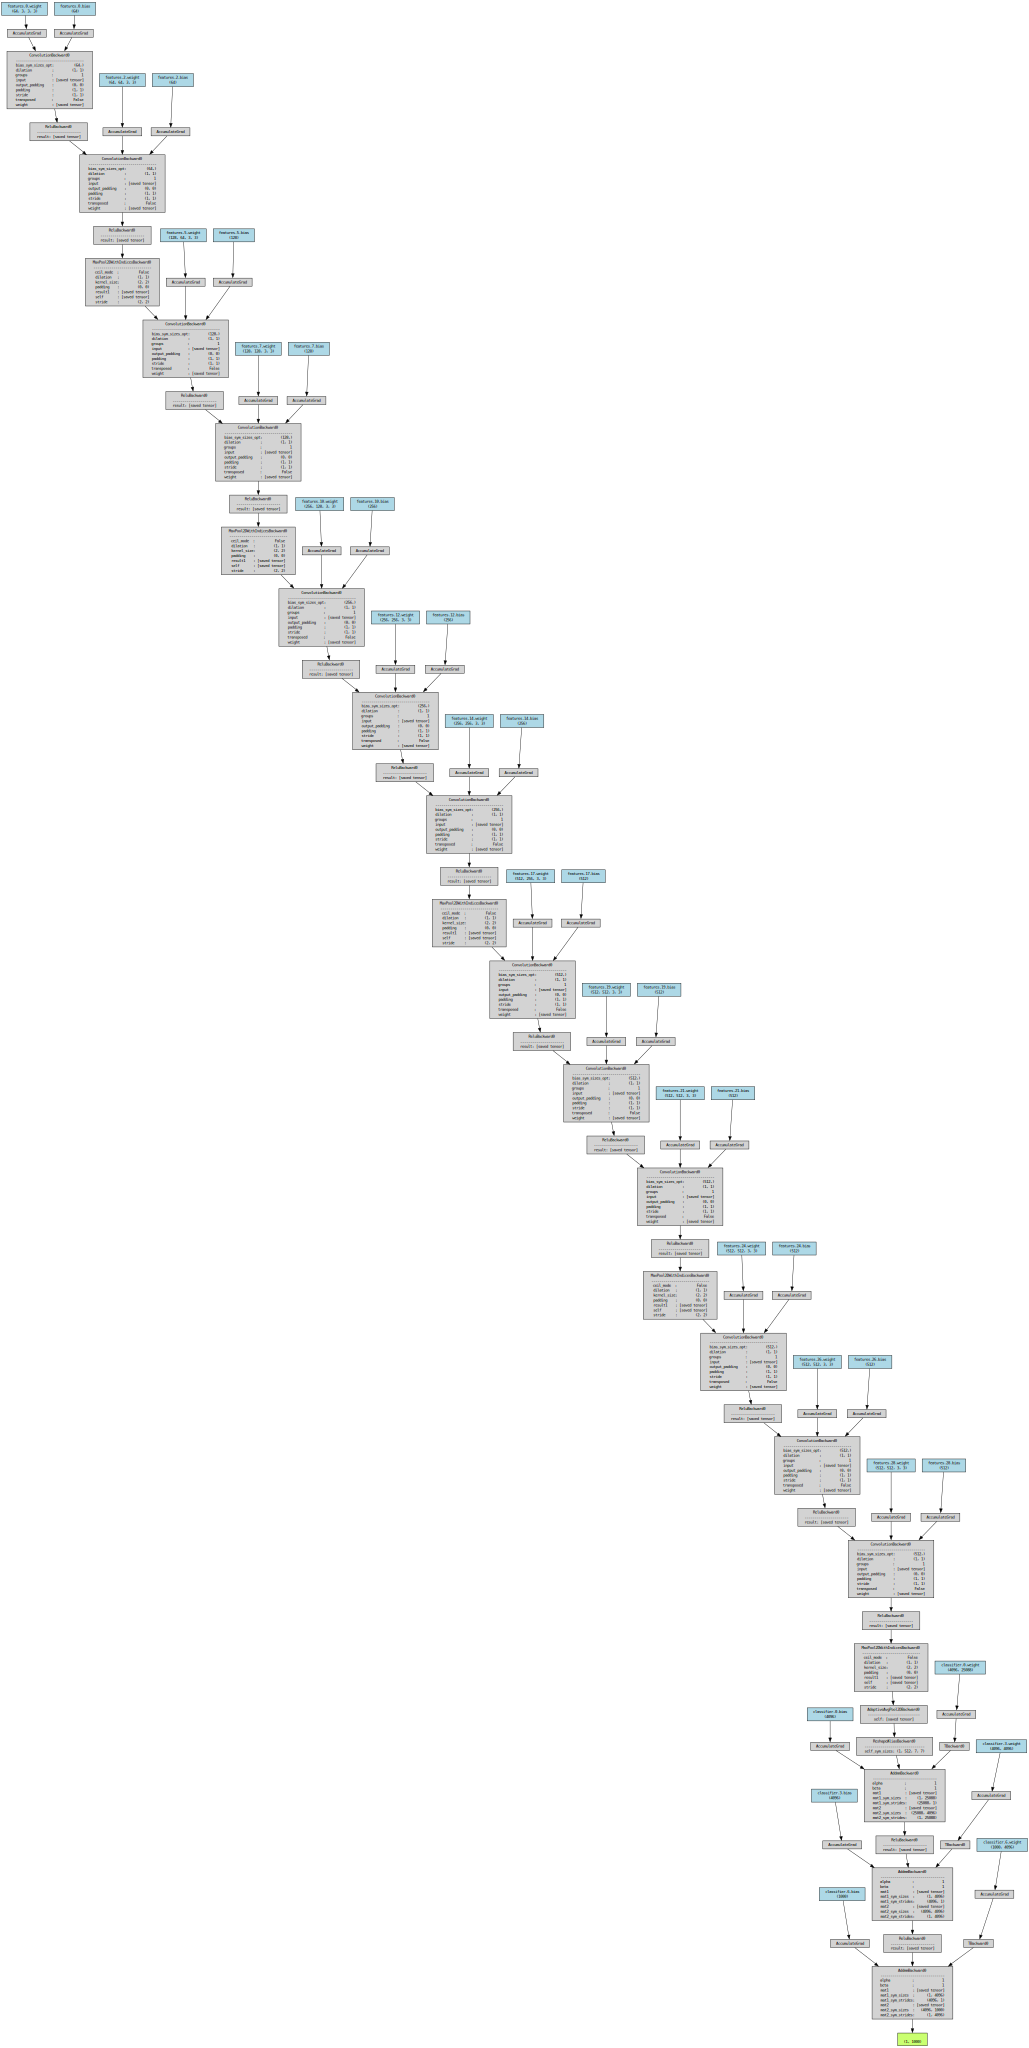

In [4]:
# size:1, channel(RGB):3, height:224, width:224
dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)
# Visualize the model
dot = torchviz.make_dot(
    output, params=dict(list(model.named_parameters())), show_attrs=True
)
dot

### 入力画像の前処理クラスを作成

画像サイズを224x224にするとともに、ILSVRC2012データセットより算出されている、平均(0.485,0.456,0.406)、標準偏差(0.229,0.224,0.225)での標準化を前処理として実行する。

また、読み込み画像は、Bing Copilotで出力したゴールデンレトリバーの画像とする。

In [5]:
class BaseTransform:
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose(
            [
                transforms.Resize(resize),  # resize the short side to the given size
                transforms.CenterCrop(resize),  # crop the given size from the center
                transforms.ToTensor(),  # convert the image to Tensor
                transforms.Normalize(
                    mean, std
                ),  # normalize the image with mean and standard deviation
            ]
        )

    def __call__(self, img):
        return self.base_transform(img)

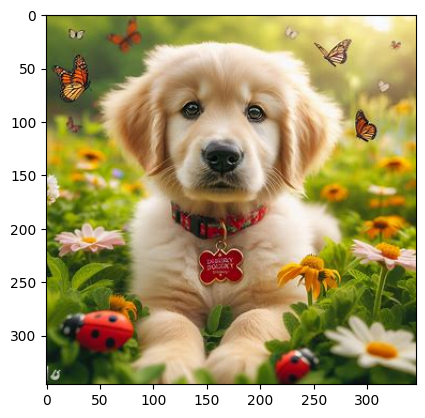

(346, 346)


In [6]:
image_file_path = "data/golden-retriever.jpeg"
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

print(img.size)

In [7]:
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
print(img_transformed.shape)
img_transformed

torch.Size([3, 224, 224])


tensor([[[ 0.2282,  0.1939,  0.1597,  ...,  2.1462,  2.1290,  2.1119],
         [ 0.2453,  0.2282,  0.2111,  ...,  2.1804,  2.1633,  2.1119],
         [ 0.2282,  0.2282,  0.2282,  ...,  2.2147,  2.1633,  2.0605],
         ...,
         [-0.8507, -1.1589, -1.4843,  ..., -1.6384, -1.6898, -1.7240],
         [-1.3815, -1.4500, -1.5014,  ..., -1.6898, -1.7583, -1.7925],
         [-1.4329, -1.4843, -1.5185,  ..., -1.6898, -1.7925, -1.8097]],

        [[ 0.6604,  0.6254,  0.5728,  ...,  2.2185,  2.2185,  2.2010],
         [ 0.6779,  0.6429,  0.6254,  ...,  2.2010,  2.2010,  2.1835],
         [ 0.6429,  0.6429,  0.6429,  ...,  2.2185,  2.1660,  2.0784],
         ...,
         [-0.4776, -0.7227, -0.9503,  ..., -1.0728, -1.1253, -1.1954],
         [-1.0378, -1.0028, -0.9503,  ..., -1.1604, -1.2479, -1.2829],
         [-1.0903, -1.0203, -0.9328,  ..., -1.2304, -1.3354, -1.3880]],

        [[-1.1073, -1.1247, -1.1247,  ...,  1.8208,  1.7511,  1.6814],
         [-1.0724, -1.0550, -1.0724,  ...,  1

表示用に、transposeで軸を入れ替える。

また、標準化を行なっているため、値が0~1の範囲に収まらないものもあるため、clipで0~1の範囲に収める。結果、変換後の画像には白っぽい部分や黒っぽい部分が増えることになる。

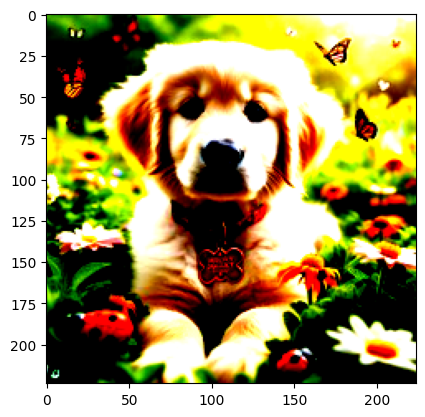

In [8]:
# (channel, height, width) -> (height, width, channel)
img_transposed_show = img_transformed.numpy().transpose((1, 2, 0))
# clip the value to [0, 1]
img_transposed_show = np.clip(img_transposed_show, 0, 1)
plt.imshow(img_transposed_show)
plt.show()

### 出力結果からラベルを予測するあと処理クラスを作成

In [9]:
# ILSVRC class labels
class_index = requests.get(
    "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
).json()
# first three of class labels
{key: value for (key, value) in list(class_index.items())[:3]}

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark']}

In [10]:
class ILSVRCPredictor:
    def __init__(self, class_index):
        """
        A class for predicting the maximum label from the output of a model trained on the ILSVRC dataset.

        Args:
            class_index (dict): A dictionary containing the class labels for the ILSVRC dataset.

        Methods:
            predict_max(out): Predicts the maximum label name from the given output tensor.
        """
        self.class_index = class_index

    def predict_max(self, out):
        """
        Predicts the maximum label name from the given output tensor.

        Args:
            out (torch.Tensor): The output tensor from the model.

        Returns:
            str: The predicted label name.
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]
        return predicted_label_name

### 学習済みのVGGモデルで手元の画像を予測

In [11]:
predictor = ILSVRCPredictor(class_index)

In [12]:
img_transformed.shape

torch.Size([3, 224, 224])

モデルに入力する際には、最初のindexはバッチサイズを指す必要がある。そのため、`unsqueeze`(squeeze=絞る、の逆ということで次元が増えることになる)を適用する。ちなみに、書籍では`unsqueeze_`を使用しているが、これは元のオブジェクトも変更する非可逆操作であり、`unsqueeze`(アンダースコアあり)では、元のオブジェクトを破壊しない。ここでは、notebookで同じセルを何回実行しても安心な`unsqueeze`の方を使用することにした。

In [13]:
inputs = img_transformed.unsqueeze(0)
inputs.shape

torch.Size([1, 3, 224, 224])

学習済みのモデルでクラスを予想。各クラスに対応する値が出力され、最大値が最も可能性の高い推測結果となる。なお、VGG16は分類問題を解くモデルだが、モデルの図を見て分かる通り、softmax関数が適用されていない。したがって、出力値は実数を取る(softmax関数が適用されていれば0~1になるはず)。

In [14]:
out = model(inputs)
print(out.shape)
out[0][:3]

torch.Size([1, 1000])


tensor([-1.1167, -0.6101, -3.0988], grad_fn=<SliceBackward0>)

copilotで作成した画像だったが、ちゃんとゴールデンレトリバーとして出力された😌

In [15]:
predictor.predict_max(out[0])

'golden_retriever'